In [6]:
from torch import Tensor

"""Verify if generalized f-mean of two gaussians is gaussian."""

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from pathlib import Path
from mmvae_hub.utils.fusion_functions import mixture_component_selection_embedding

from torch.distributions import MultivariateNormal
from mmvae_hub.utils.dataclasses.Dataclasses import *

In [7]:
BATCHSIZE = 1000
N_DIM = 2
P = MultivariateNormal(torch.zeros(N_DIM), torch.eye(N_DIM))

In [8]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512, dims_out))


# a simple chain of operations is collected by ReversibleSequential
flow = Ff.SequenceINN(N_DIM)
for k in range(8):
    flow.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

Train flow such that f-mean of three moon distributions gives a std. normal distr.

Here, the flow needs to be both a mapping from Moon distributions to a std. normal distribution and an inverse transformation from a somewhat std. normal distr to a normal distr

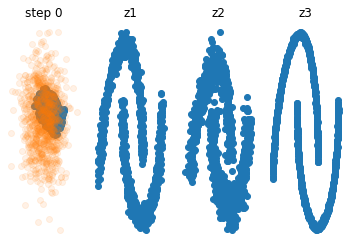

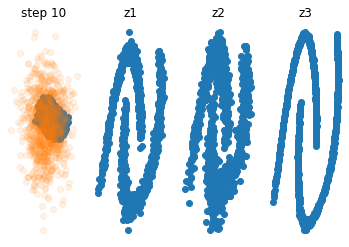

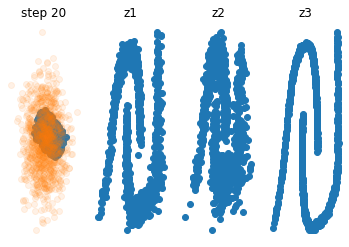

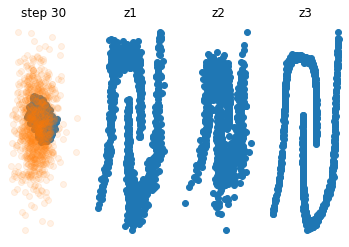

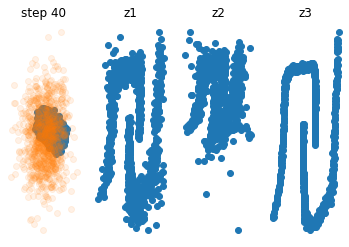

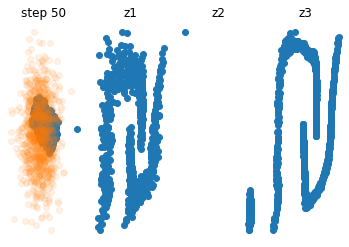

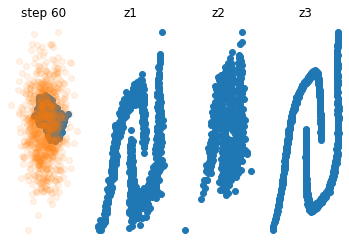

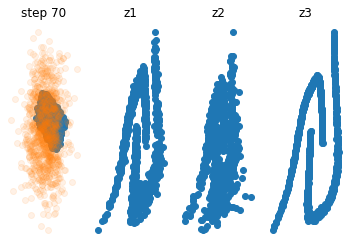

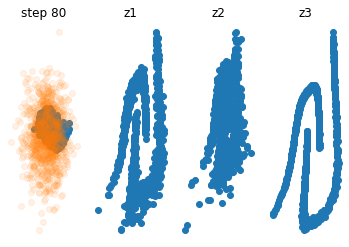

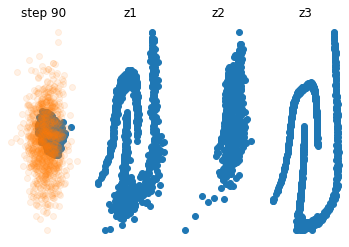

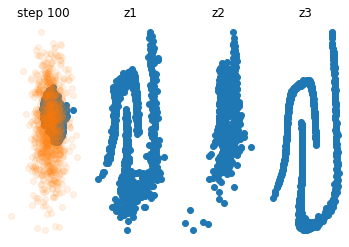

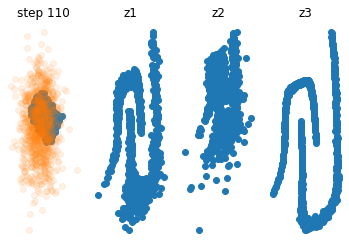

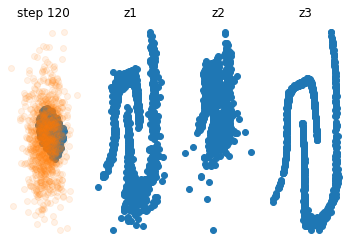

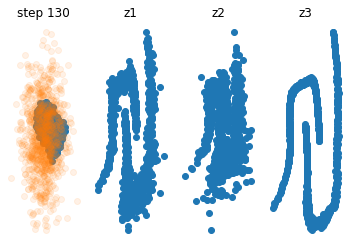

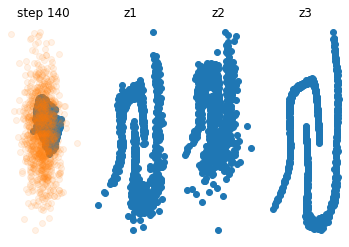

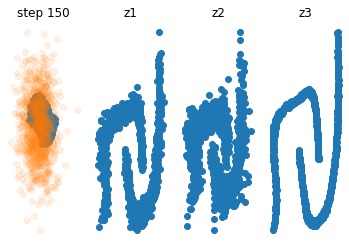

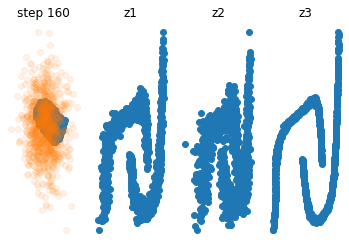

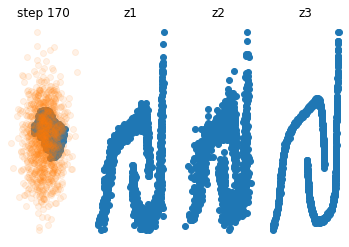

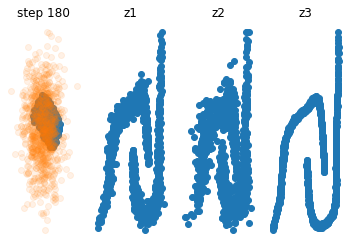

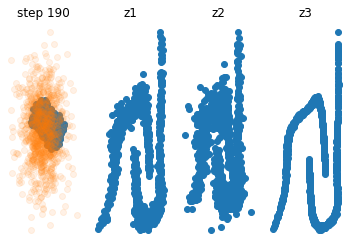

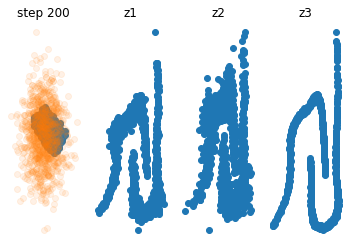

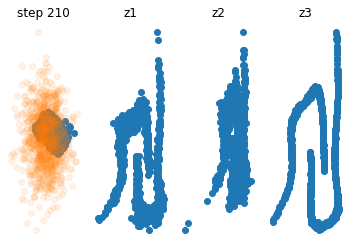

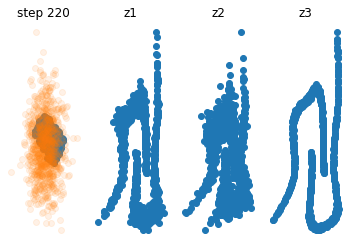

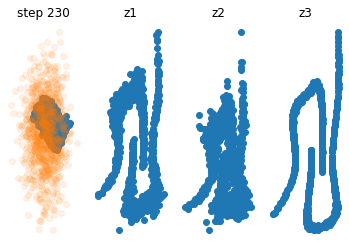

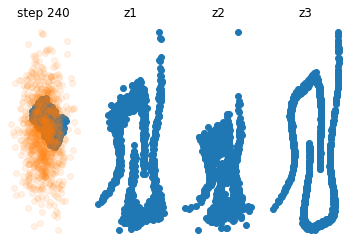

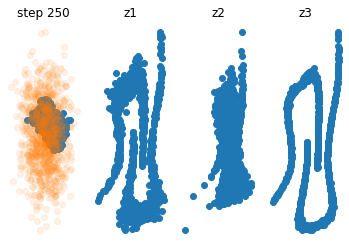

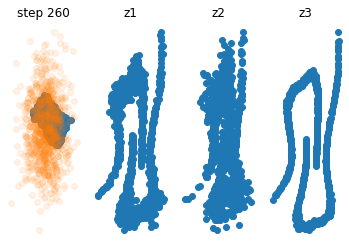

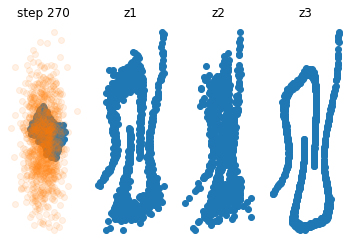

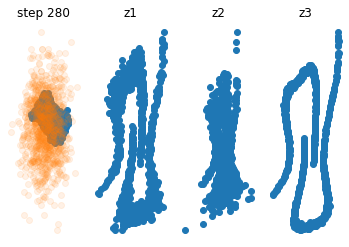

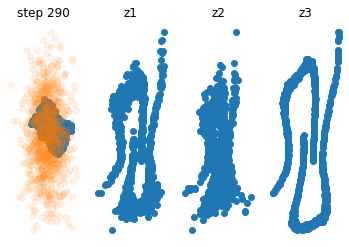

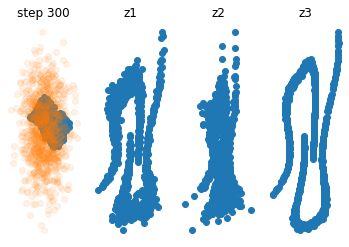

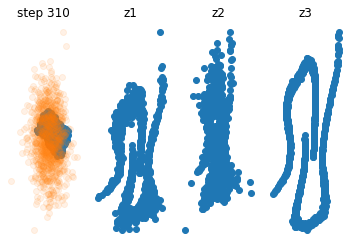

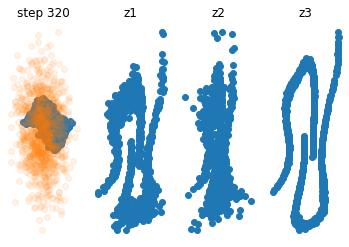

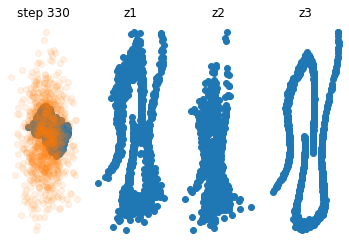

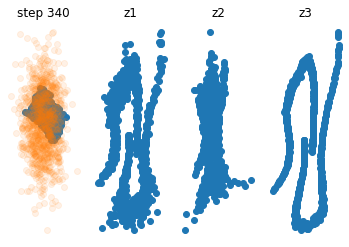

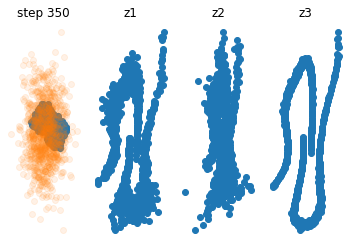

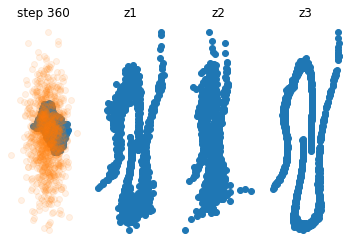

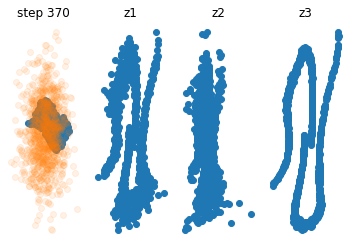

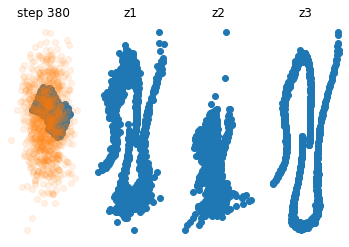

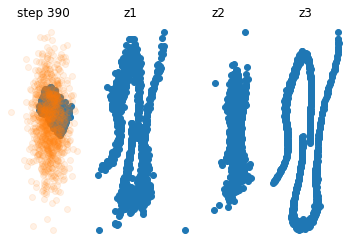

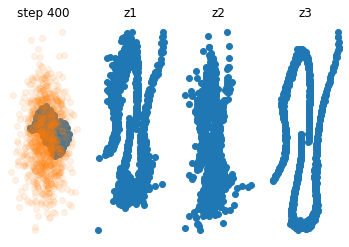

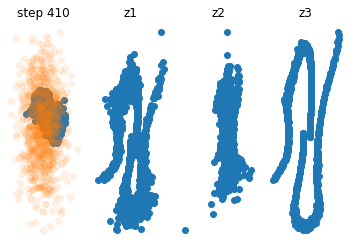

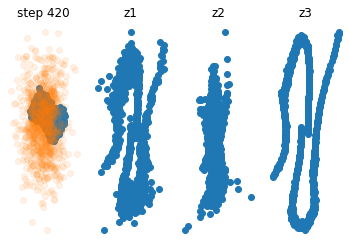

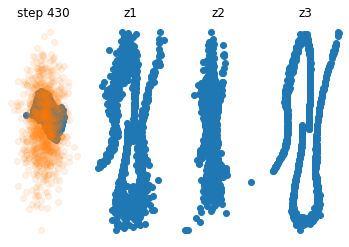

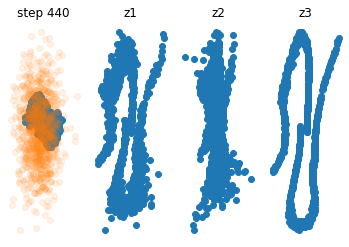

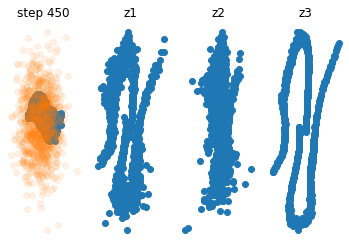

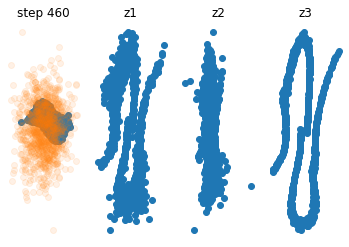

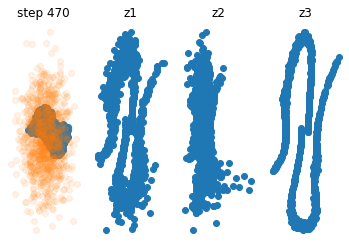

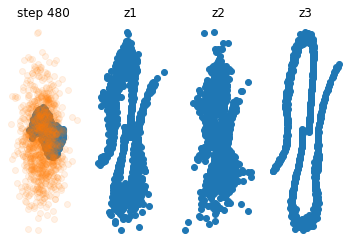

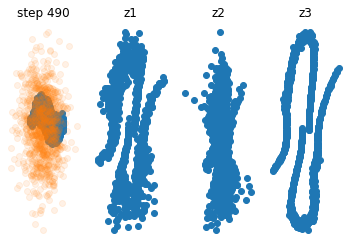

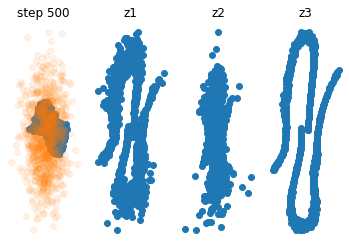

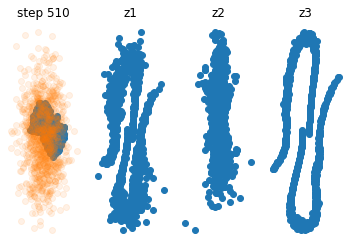

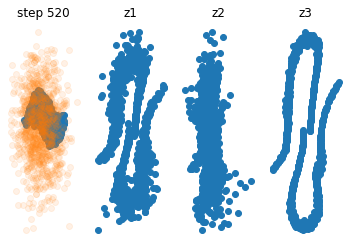

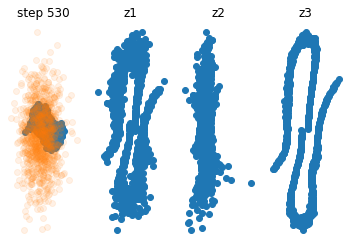

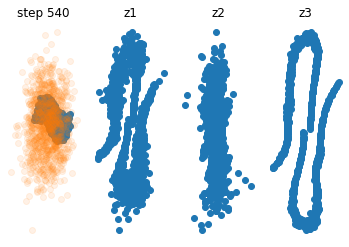

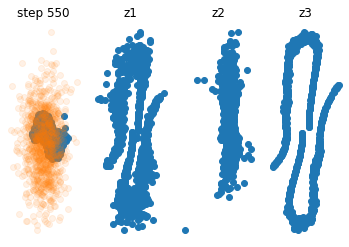

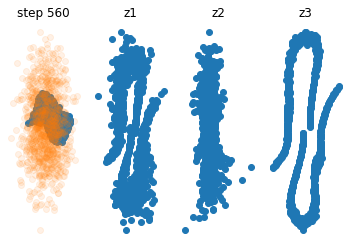

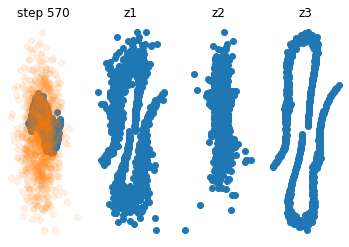

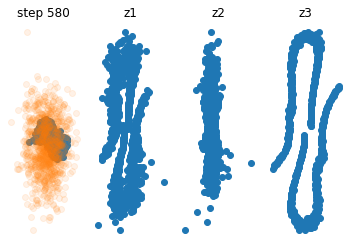

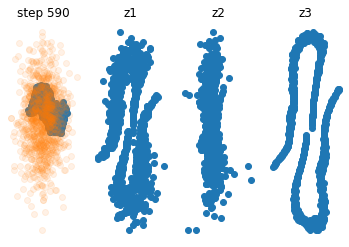

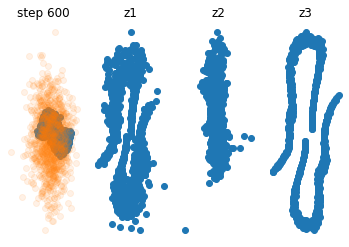

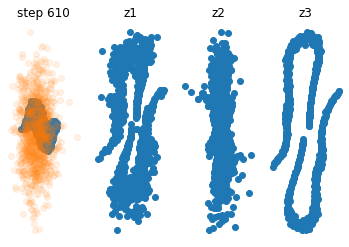

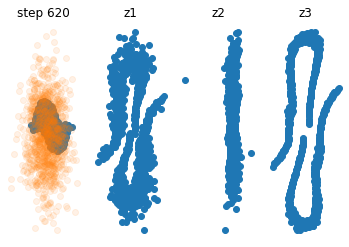

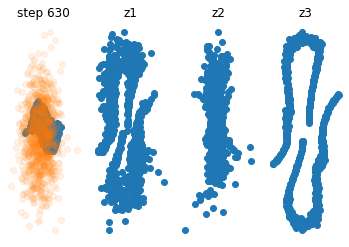

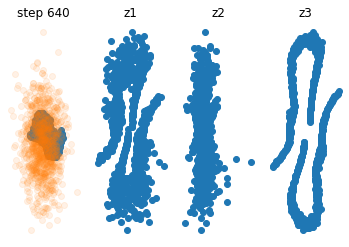

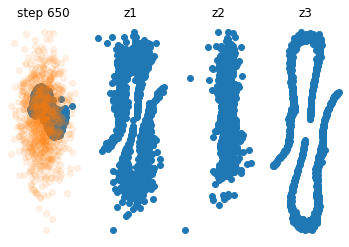

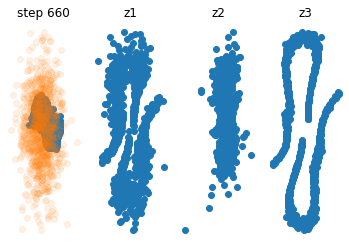

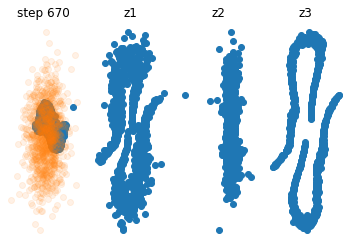

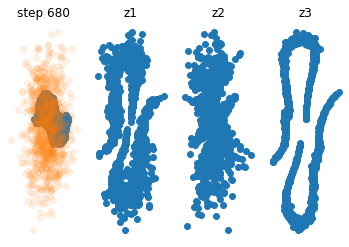

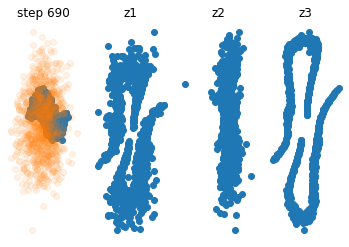

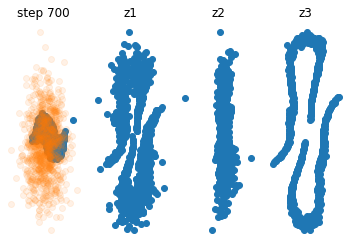

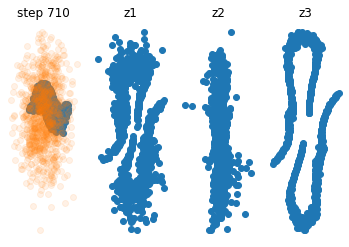

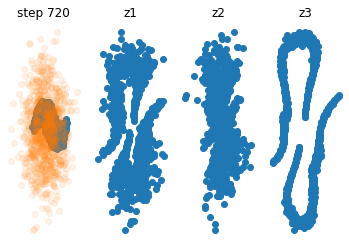

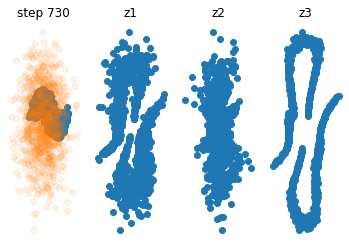

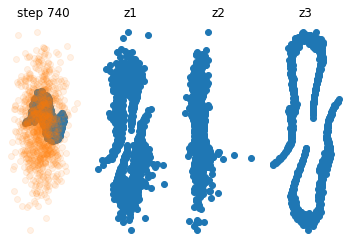

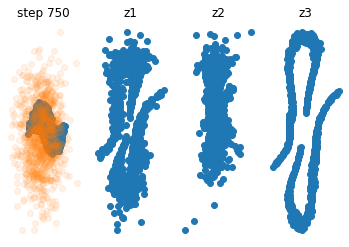

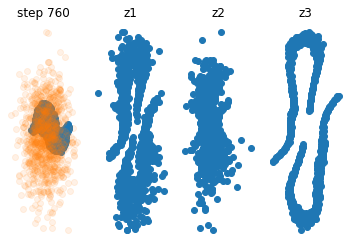

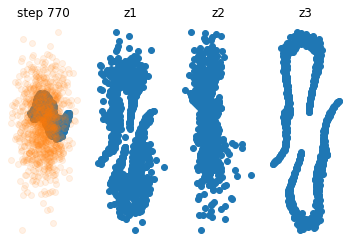

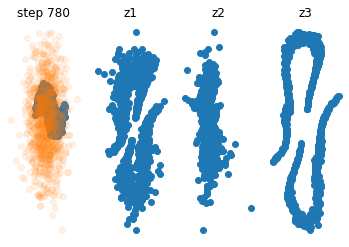

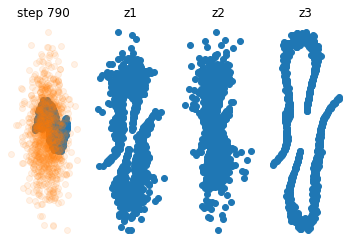

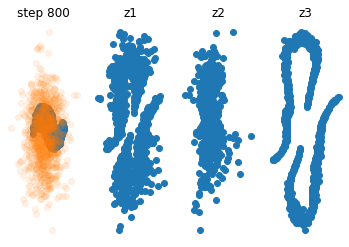

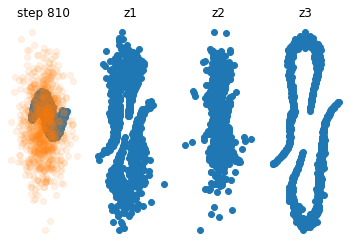

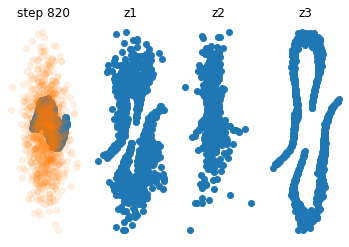

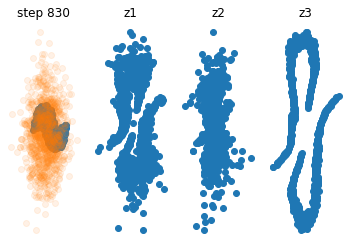

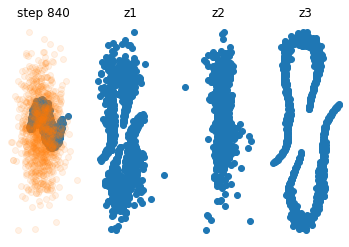

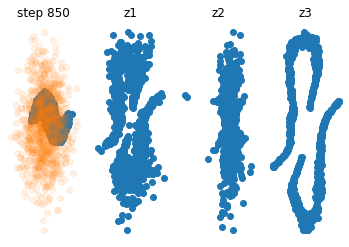

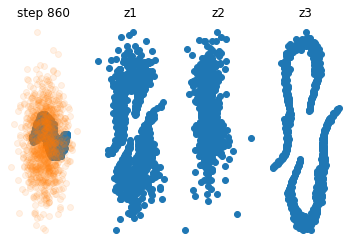

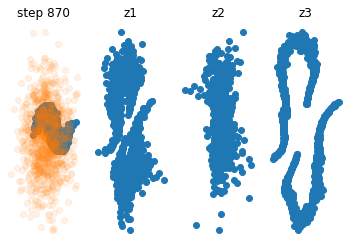

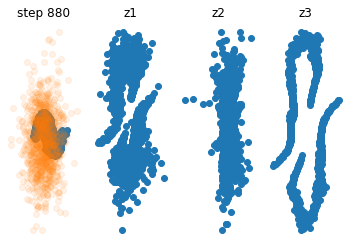

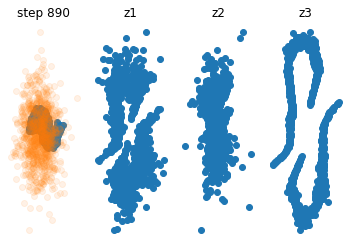

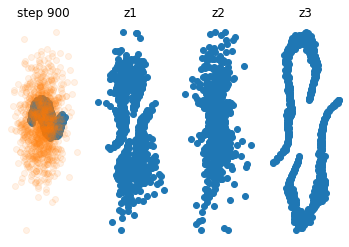

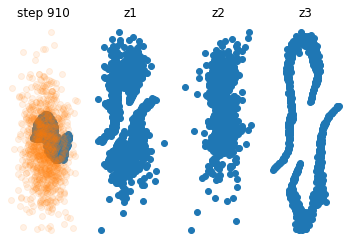

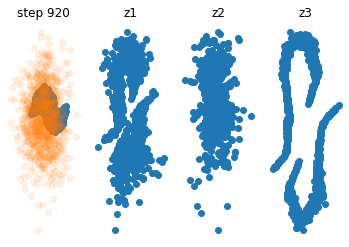

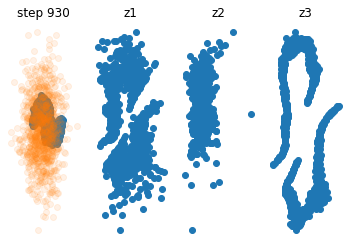

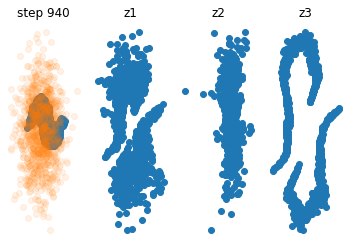

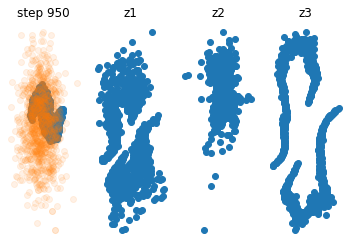

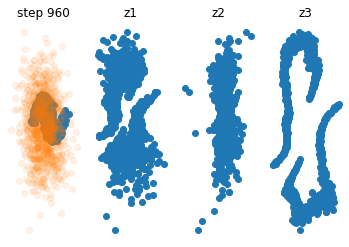

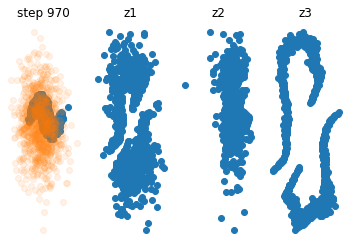

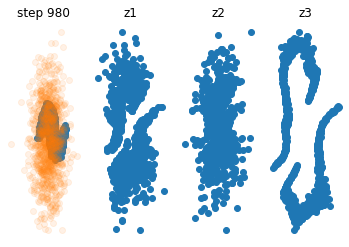

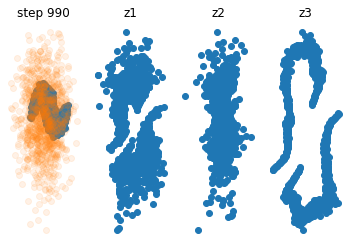

In [9]:
losses = []
state_dict_path = Path('flow_moon')
if state_dict_path.exists():
# if False:
    flow.load_state_dict(torch.load(state_dict_path))
    moon_data, _ = make_moons(n_samples=BATCHSIZE, noise=0.05)
else:
    optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

    for i in range(1000):
        optimizer.zero_grad()
        # sample data from the moons distribution
        m1, _ = make_moons(n_samples=BATCHSIZE, noise=0.05)
        m2, _ = make_moons(n_samples=BATCHSIZE, noise=0.1)
        m3, _ = make_moons(n_samples=BATCHSIZE, noise=0.01)

        z1, log_jac_det1 =  flow(torch.Tensor(m1))
        z2, log_jac_det2 =  flow(torch.Tensor(m2))
        z3, log_jac_det3 =  flow(torch.Tensor(m3))

        zmean = torch.cat([e.unsqueeze(dim=0) for e in [z1,z2,z3]]).mean(0)

        z, log_jac_det = flow(zmean, rev=True)

        # calculate the negative log-likelihood of the model with a standard normal prior
        loss1 = 0.5 * torch.sum(z1 ** 2, 1) - log_jac_det1
        loss2 = 0.5 * torch.sum(z2 ** 2, 1) - log_jac_det2
        loss3 = 0.5 * torch.sum(z3 ** 2, 1) - log_jac_det3
        lossmean = 0.5 * torch.sum(zmean ** 2, 1) - log_jac_det
        # lossmean = 0.5 * torch.sum(zmean ** 2, 1)
        loss = torch.cat([e.unsqueeze(dim=0) for e in [loss1,loss2,loss3, lossmean]]).mean(0)
        loss = loss.mean() / N_DIM
        # backpropagate and update the weights
        loss.backward()
        optimizer.step()
        losses.append(loss)

        if i%10 == 0:
            plt.figure()
            plt.subplot(1,4,1)
            p = P.sample((BATCHSIZE,))
            z_detached = z.detach().numpy()
            plt.title(f'step {i}')
            plt.scatter(z_detached[:, 0], z_detached[:, 1])
            plt.scatter(p[:,0], p[:, 1], alpha = 0.1)
            plt.axis('off')

            plt.subplot(1,4,2)
            plt.title(f'z1')
            z1_detached = z1.detach().numpy()
            plt.scatter(z1_detached[:, 0], z1_detached[:, 1])
            plt.axis('off')

            plt.subplot(1,4,3)
            plt.title(f'z2')
            z2_detached = z2.detach().numpy()
            plt.scatter(z2_detached[:, 0], z2_detached[:, 1])
            plt.axis('off')

            plt.subplot(1,4,4)
            plt.title(f'z3')
            z3_detached = z3.detach().numpy()
            plt.scatter(z3_detached[:, 0], z3_detached[:, 1])
            plt.axis('off')

            plt.show()
    torch.save(flow.state_dict(), 'flow')

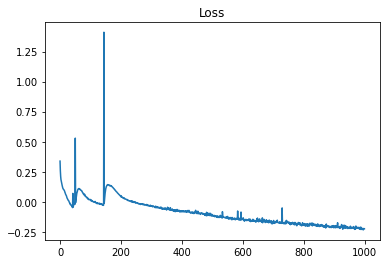

In [10]:
plt.plot(losses)
plt.title('Loss')
plt.show()

Same for Normal sitributions instead of moon distributions

In [11]:
def reparameterize(distr, eps):
    """
    Samples z from a multivariate Gaussian with diagonal covariance matrix using the
     reparameterization trick.
    """

    std = torch.diag(distr.scale_tril).sqrt()
    return eps.mul(std).add_(distr.loc)

In [12]:
M1 = MultivariateNormal(torch.rand(N_DIM), torch.eye((N_DIM)) * torch.rand(N_DIM))
M2 = MultivariateNormal(torch.rand(N_DIM), torch.eye((N_DIM)) * torch.rand(N_DIM))
M3 = MultivariateNormal(torch.rand(N_DIM), torch.eye((N_DIM)) * torch.rand(N_DIM))




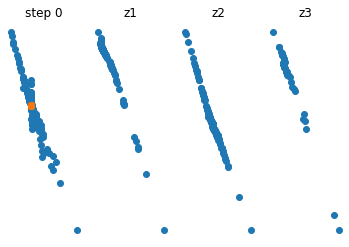

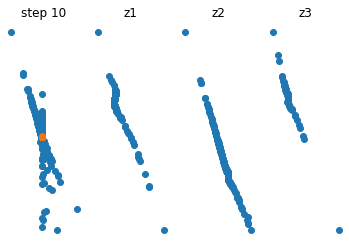

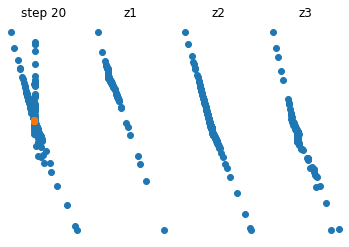

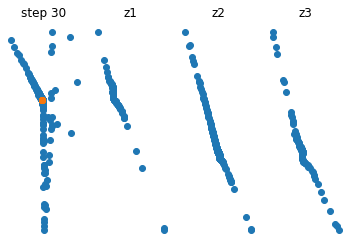

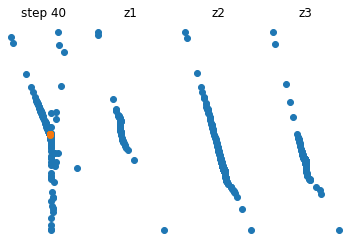

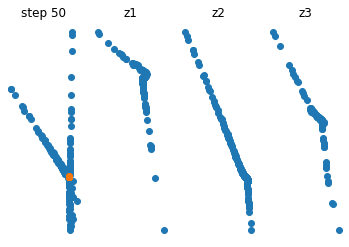

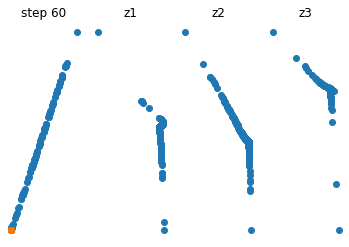

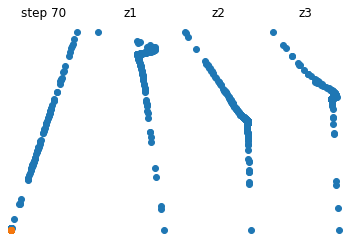

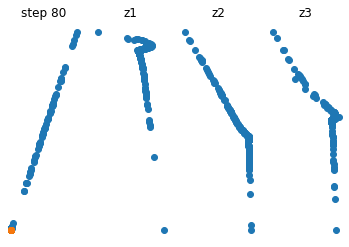

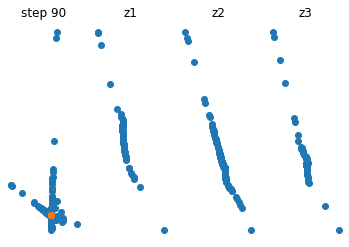

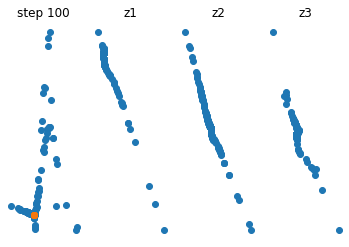

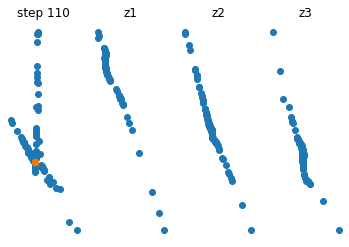

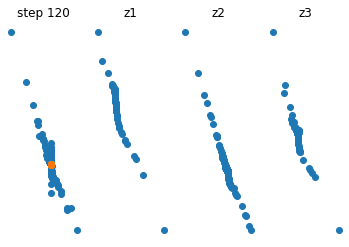

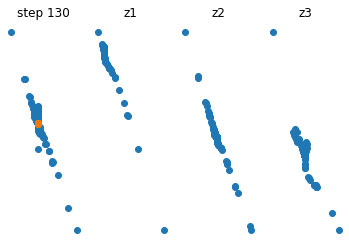

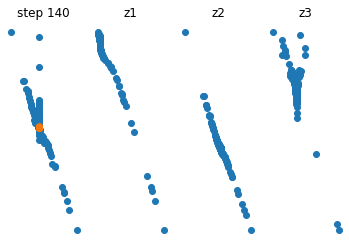

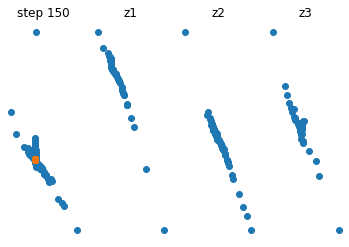

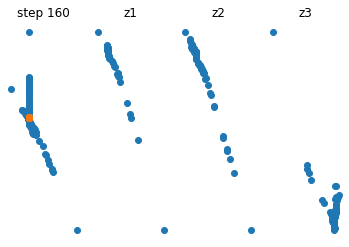

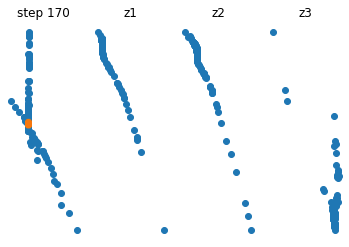

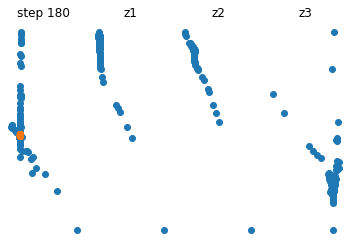

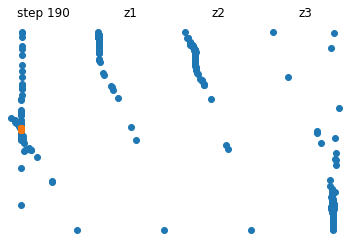

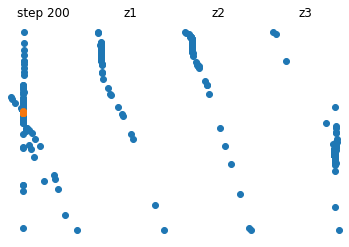

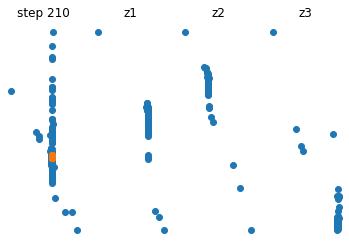

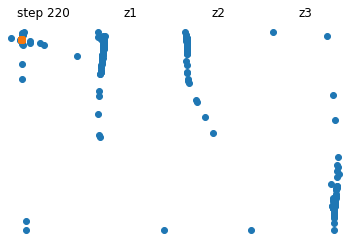

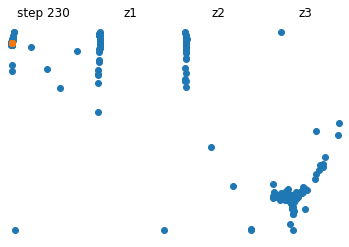

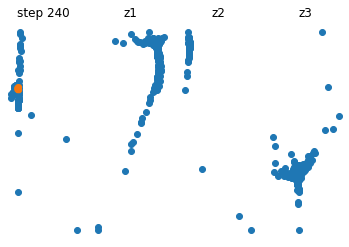

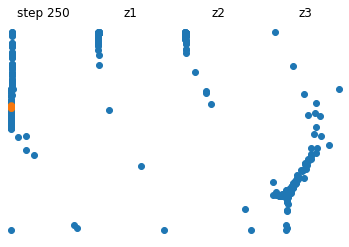

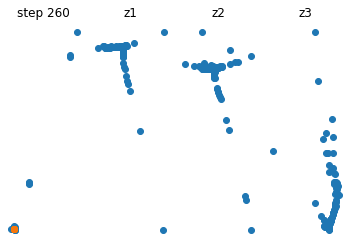

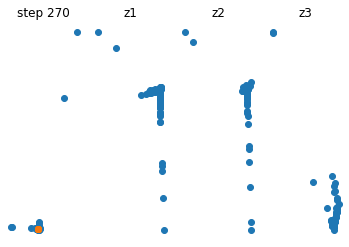

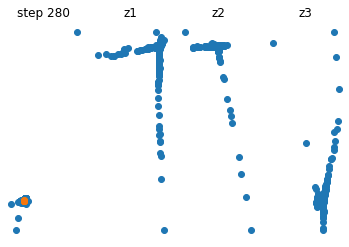

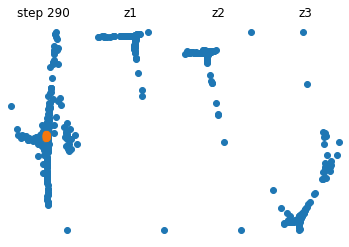

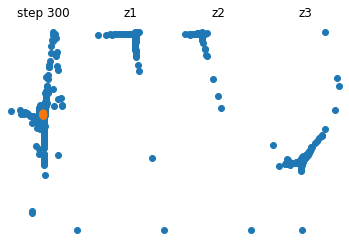

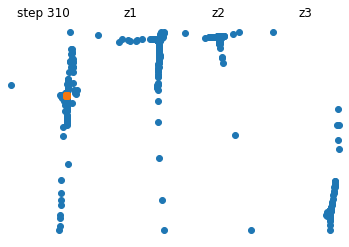

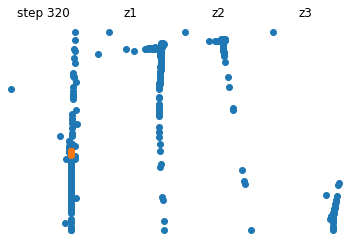

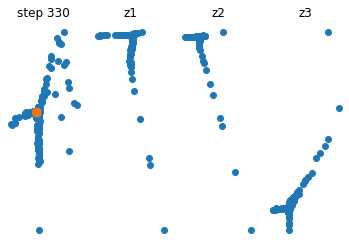

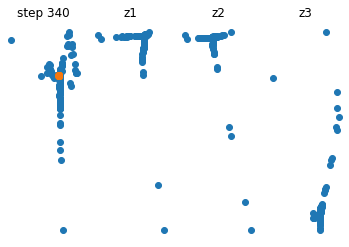

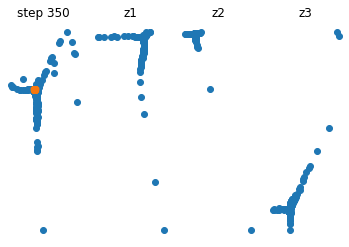

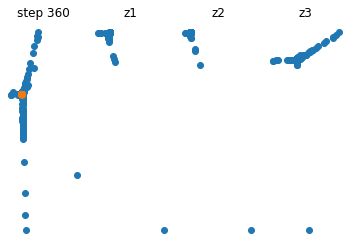

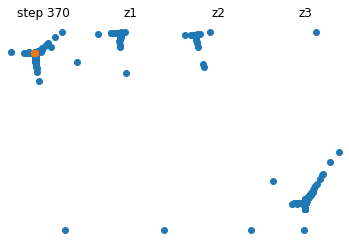

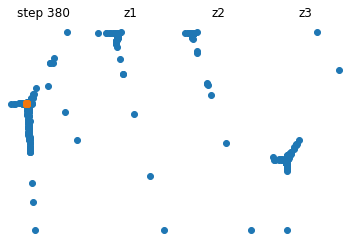

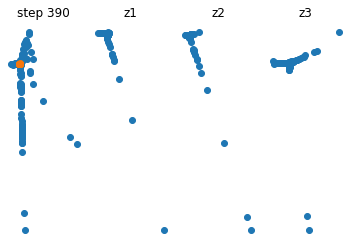

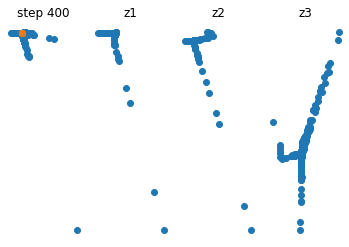

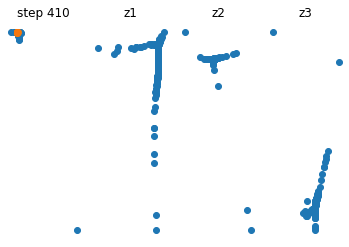

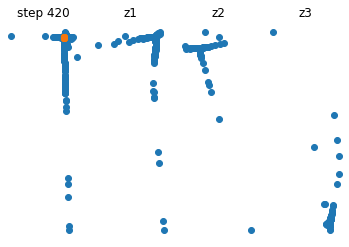

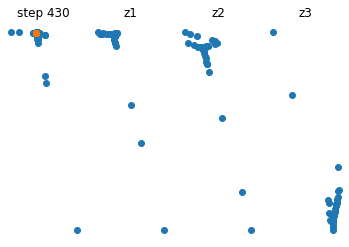

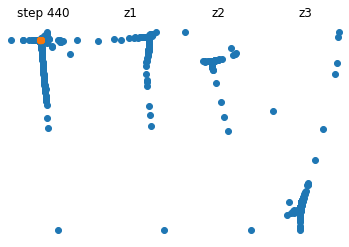

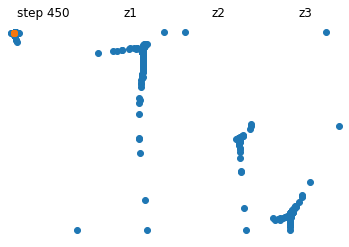

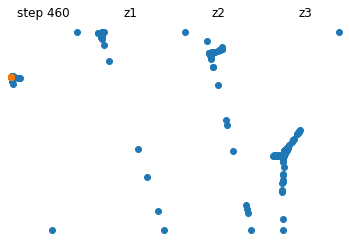

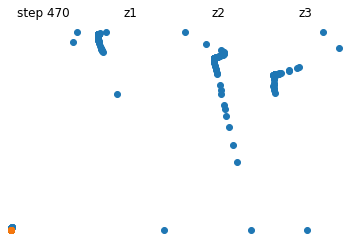

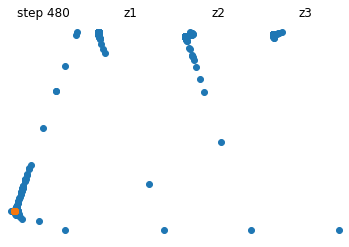

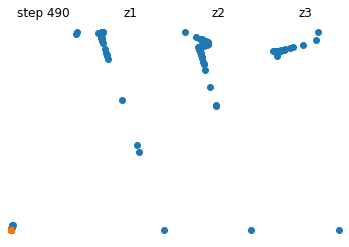

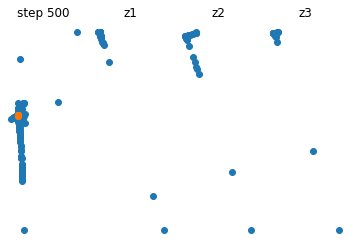

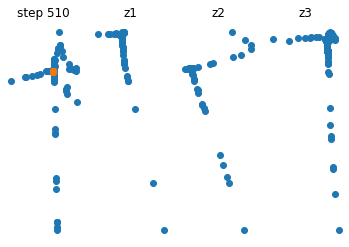

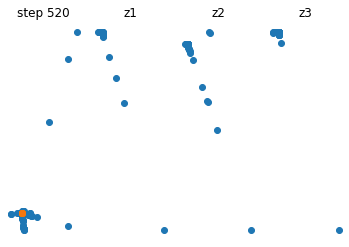

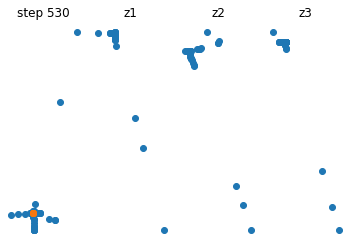

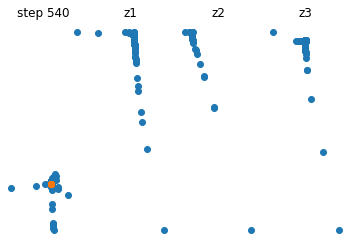

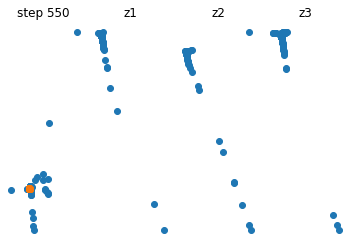

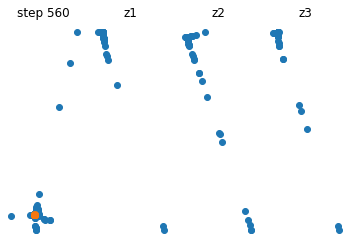

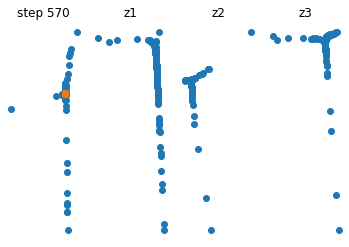

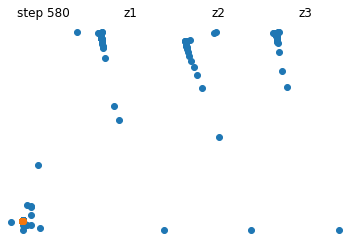

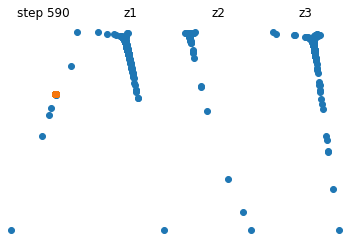

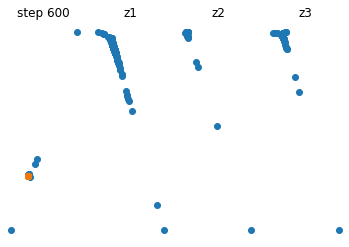

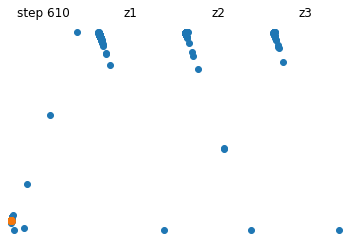

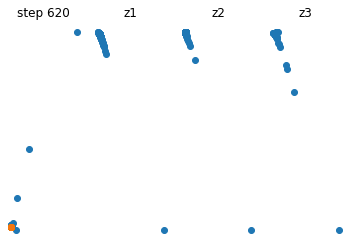

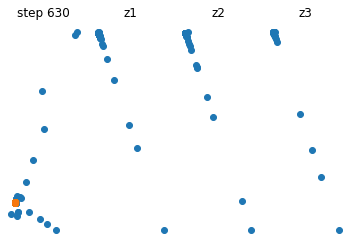

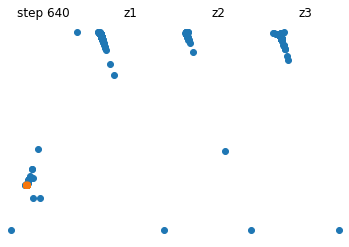

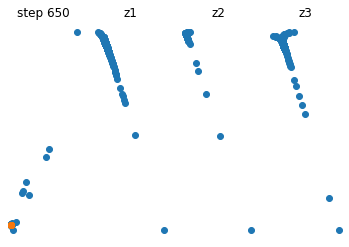

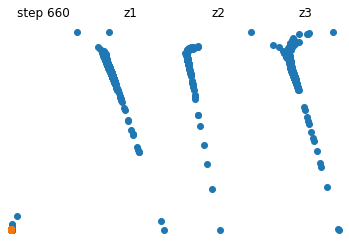

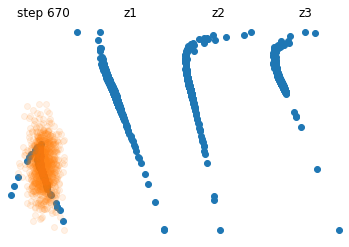

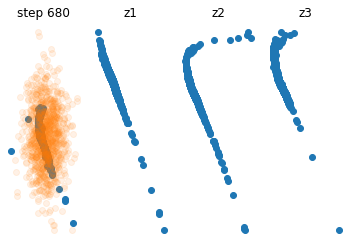

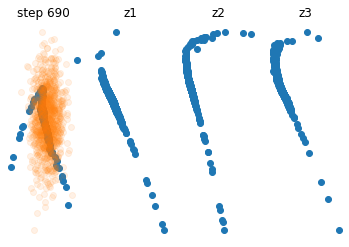

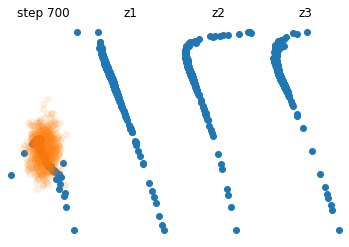

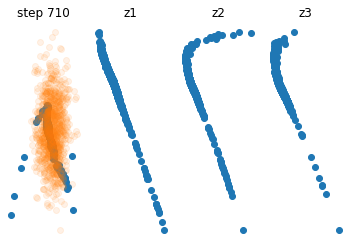

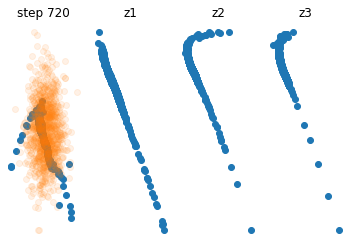

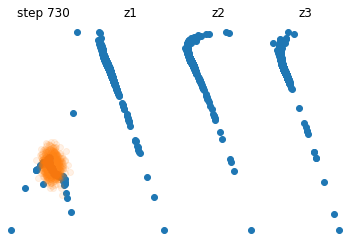

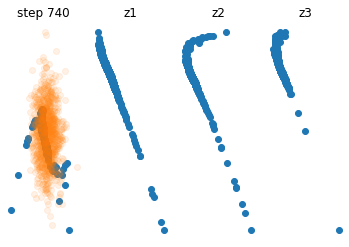

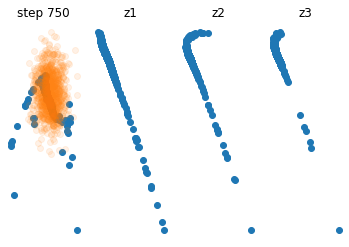

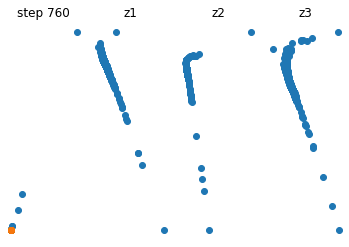

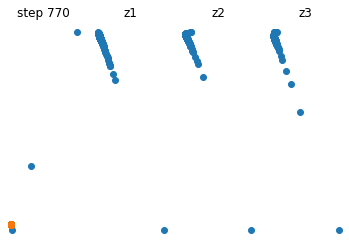

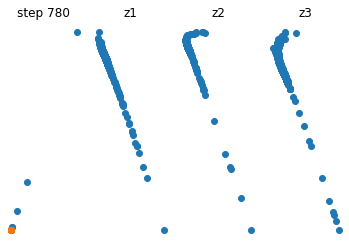

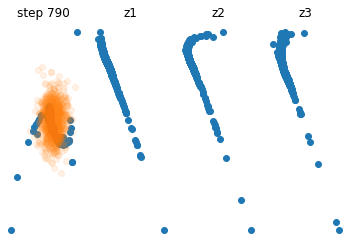

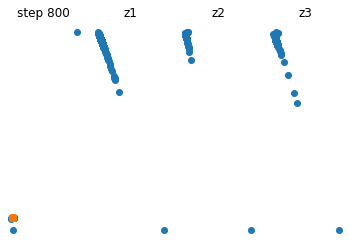

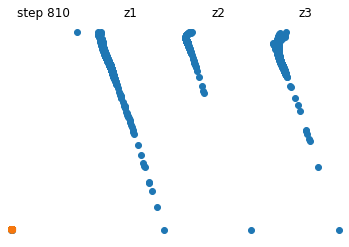

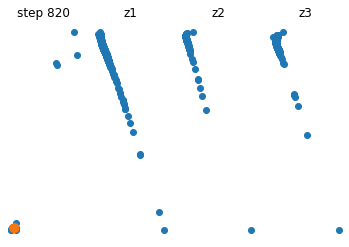

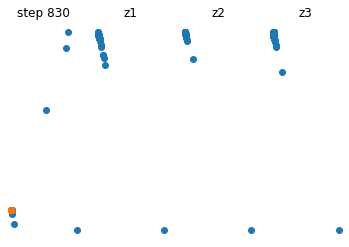

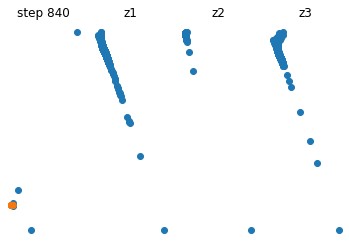

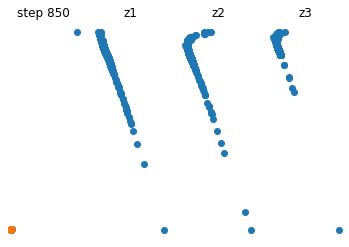

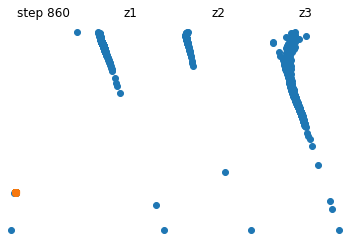

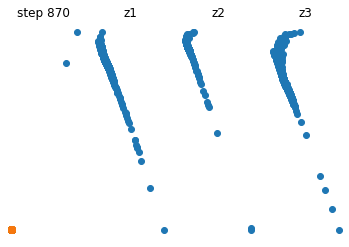

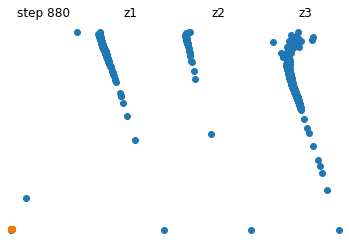

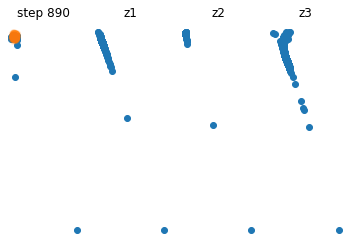

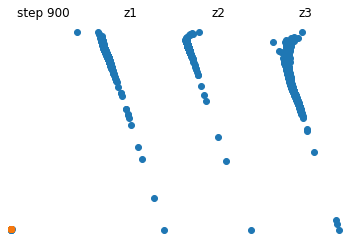

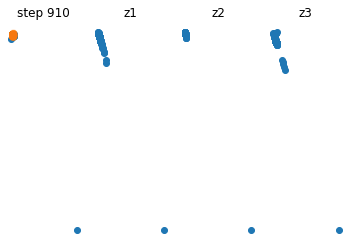

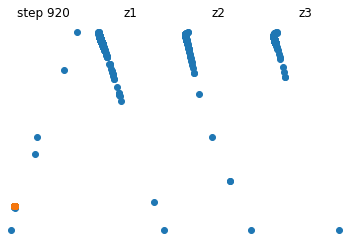

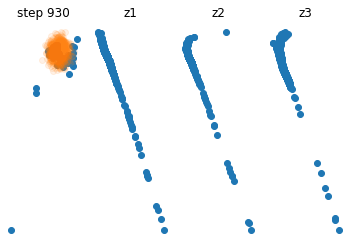

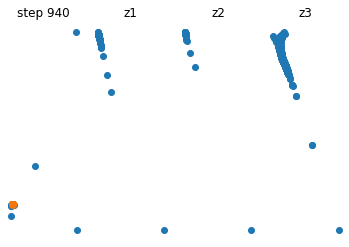

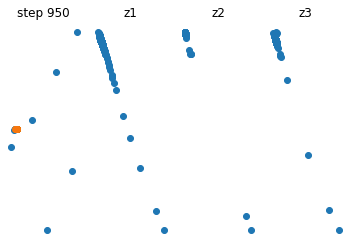

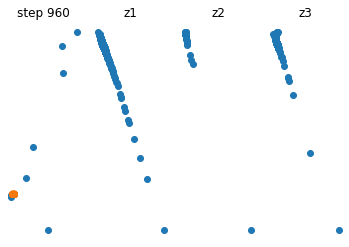

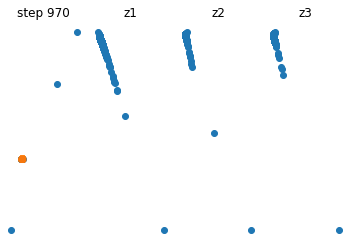

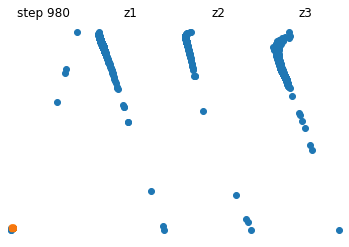

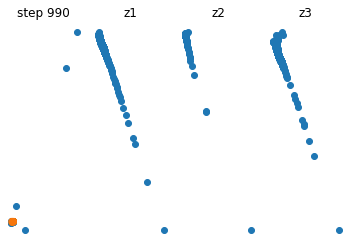

In [13]:
optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

for i in range(1000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    m1, _ = make_moons(n_samples=BATCHSIZE, noise=0.05)
    m2, _ = make_moons(n_samples=BATCHSIZE, noise=0.1)
    m3, _ = make_moons(n_samples=BATCHSIZE, noise=0.01)
    
    epss = P.sample((BATCHSIZE,))    
    z1 = flow(torch.cat([reparameterize(M1, eps).unsqueeze(0) for eps in epss]))[0]
    z2 = flow(torch.cat([reparameterize(M2, eps).unsqueeze(0) for eps in epss]))[0]
    z3 = flow(torch.cat([reparameterize(M3, eps).unsqueeze(0) for eps in epss]))[0]


    z = flow(torch.cat([flow(e)[0].unsqueeze(dim=0) for e in [z1,z2,z3]]).mean(0),rev=True)[0]

    log_probs = torch.cat([M.log_prob(z).unsqueeze(0) for M in [M1,M2,M3]]).mean(0)

    Dkl = log_probs.exp() *( log_probs - P.log_prob(epss))

    loss = Dkl.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()
    losses.append(loss)

    if i%10 == 0:
        plt.figure()
        plt.subplot(1,4,1)
        p = P.sample((BATCHSIZE,))
        z_detached = z.detach().numpy()
        plt.title(f'step {i}')
        plt.scatter(z_detached[:, 0], z_detached[:, 1])
        plt.scatter(p[:,0], p[:, 1], alpha = 0.1)
        plt.axis('off')

        plt.subplot(1,4,2)
        plt.title(f'z1')
        z1_detached = z1.detach().numpy()
        plt.scatter(z1_detached[:, 0], z1_detached[:, 1])
        plt.axis('off')

        plt.subplot(1,4,3)
        plt.title(f'z2')
        z2_detached = z2.detach().numpy()
        plt.scatter(z2_detached[:, 0], z2_detached[:, 1])
        plt.axis('off')

        plt.subplot(1,4,4)
        plt.title(f'z3')
        z3_detached = z3.detach().numpy()
        plt.scatter(z3_detached[:, 0], z3_detached[:, 1])
        plt.axis('off')

        plt.show()
torch.save(flow.state_dict(), 'flow')

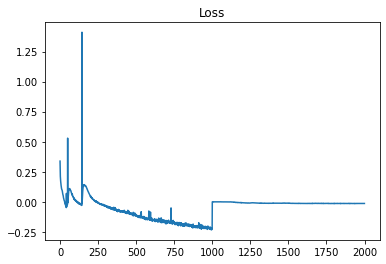

In [14]:
plt.plot(losses)
plt.title('Loss')
plt.show()